# Lecture 3: Linear Algebra II

Topics:

* Least Square
* Eigenvalue and Eigenvector 
* QR Decomposition
* Principal Component Analysis
* Singular Value Decomposition

$\renewcommand{bt}[1]{\bs{\tilde #1}} $ 

In [1]:
# initialize the environment
%pylab inline
import sympy as sp
import fmt
import pandas as pd

sp.init_printing(use_latex = True)
from IPython.display import display
lecture = 3

Populating the interactive namespace from numpy and matplotlib


# Least Square

Robert Wilson: Consciousness itself is an infinite regress. This explains coincidences. 

## Least square problem

Given an unknown scalar function $\renewcommand{bs}{\boldsymbol} y = y(\boldsymbol x)$, where the argument $\bs x$ is a $n$ dimensional vector.

* We have $m > n$ observations: $X$ represents inputs and $\bs y$ represents outputs:

 $$\small X = \pmatrix{\bs x_1^T \\ \bs x_2^T \\ \vdots \\ \bs x_m^T}, \;\; \bs y = \pmatrix{y_1 \\ y_2 \\ \vdots \\ y_m}$$
 
* We want to find a factor loading vector $\bs \beta$ so that the linear function $\hat y = \bs x^T \bs \beta$ is the best aproximation to the observed inputs/outputs.
* $X \bs \beta = \bs y$ is over-determined, no vector $\bs \beta$ solves it exactly
* Instead, we find the $\bs \beta^* $ that minimizes $\Vert X \bs{\beta - y}\Vert_2$.

## Pseudo inverse:

$$ \bs \beta^* = \text{argmin}_{\bs {\beta}} \Vert X \bs{\beta - y} \Vert_2$$
Which can be easily solved using Matrix calculus:

$$\begin{eqnarray}
\Vert X \bs{\beta - y} \Vert_2^2 &=& (X \bs{\beta - y})^T (X \bs{\beta - y}) \\
&=& \bs{\beta}^T X^T X \bs{\beta} - 2 \bs{\beta}^TX^T\bs y + \bs y^T\bs y\\
\frac{\partial}{\partial \bs \beta^T} \Vert X \bs{\beta - y} \Vert_2^2 &=& 2 X^TX \bs \beta  - 2X^T \bs y  = \bs 0 \\
\bs \beta^* &=& (X^TX)^{-1}X^T\bs y
\end{eqnarray}$$

* The solution is equivalent to linear regression, but beware the difference
* $X^+ = (X^TX)^{-1}X^T$ is also known as the psuedo inverse of $X$ because $X^+X = I$
  * note $XX^+$ is not even a valid matrix multiplication. 

## Condition number of non-square matrix

We already proved that an invertable matrix $A$'s condition number is 

$$k(A) = \Vert A \Vert \Vert A^{-1} \Vert$$

We can extend this to non-square matrix using pseudo-inverse, following the same proof.

$$k(A) = \Vert A \Vert \Vert A^{+} \Vert$$


## Ridge regression

The $\bs \beta$ that solves the least square problem may have large magnitude:
* often cause problems in practice

Ridge regression adds a magnitude penalty to the objective function of least square: 

$$\begin{eqnarray} l(\bs \beta) &=& \Vert X \bs{\beta - y} \Vert_2^2 + \lambda \Vert W \bs \beta \Vert_2^2 \\ &=&  \bs{\beta}^T X^T X \bs{\beta} - 2 \bs{\beta}^TX^T\bs y + \bs y^T \bs y + \lambda \bs \beta^T W^TW \bs \beta \\
\frac{\partial l}{\partial \bs \beta^T} &=& 2X^TX \bs \beta   - 2X^T \bs y + 2 \lambda W^T W \bs \beta = \bs 0 \\
\bs \beta &=& (X^TX + \lambda W^TW)^{-1}X^T\bs y
\end{eqnarray}$$

* $W$ is a diagonal weighting matrix for the elements in $\bs \beta$, e.g. $W = I$ is often a good start
* $\lambda$ is a scaler penalty rate

## Ridge regression example

We draw many pairs of $x, y, z$ from the following linear model: 

$$  y = 2x + 0.1z + 5 + \epsilon $$

* $x, z$ are standard normal, $z$ represent an insignificant feature (or accidental correlation)
* $\epsilon$ is a standard normal noise

We regress the vector $\bs y$ against $X = [\bs x, \bs x + .0001 \bs z, \bs 1]$:

In [2]:
import pandas as pd

n = 5000
x = np.random.normal(size=n)
z = np.random.normal(size=n)
y = 2*x + 5 + 0.1*z + np.random.normal(size=n)

xs = np.array([x, x + 0.0001*z, np.ones(len(x))]).T

q = np.eye(len(xs.T))
lbd = .1
b_ols = np.linalg.inv(xs.T.dot(xs)).dot(xs.T).dot(y)
e_ols = np.linalg.norm(y - xs.dot(b_ols), 2)

b_rr = np.linalg.inv(xs.T.dot(xs) + lbd*q.T.dot(q)).dot(xs.T).dot(y)
e_rr = np.linalg.norm(y - xs.dot(b_rr), 2)

df = pd.DataFrame(np.array([b_ols, b_rr]), index=['Least square', 'Ridge regression $\\lambda=%2g$' % lbd], 
                  columns=['$\\bs x$', '$\\bs x+.0001\\bs z$', '$\\bs 1$'])
df['$\Vert X\\bs \\beta - \\bs y \\Vert_2$'] = [e_ols, e_rr]
fmt.displayDF(df, "4g")

,$\bs x$,$\bs x+.0001\bs z$,$\bs 1$,$\Vert X\bs \beta - \bs y \Vert_2$
Least square,"-1,044","1,046",4.987,70.54
Ridge regression $\lambda=0.1$,0.736,1.25,4.985,70.92


* ridge regression is more robust, it works even if $X$ is not fully ranked (colinearity)
* often used for constructing hedging portfolios

## Regularization

Ridge regression is an example of regularization. Two other popular regularizations are:

* LASSO regression: resulting in sparse $\bs \beta$

$$
l(\bs \beta) = \Vert X \bs{\beta - y} \Vert_2^2 + \lambda \Vert W \bs \beta \Vert_1
$$

* Elasticnet: in between LASSO and Ridge

$$
l(\bs \beta) = \Vert X \bs{\beta - y} \Vert_2^2 + \lambda_1 \Vert W \bs \beta \Vert_1 + \lambda_2 \Vert W \bs \beta \Vert_2^2
$$

Both LASSO and elasticnet reduce to support vector machine (SVM).

# Eigenvalues and Eigenvectors

eigen-: characteristic, origin: German

## Definitions

For a square matrix $A$ of size $n \times n$, if there exists a vector $\bs {v \ne 0}$ and a scalar $\lambda \ne 0$ so that:

$$ A \bs v = \lambda \bs v $$

* $\bs v$ is an eigenvector,  $\lambda$ is the corresponding eigenvalue
* $A$ only changes $\bs v$'s magnitude, but not direction
* $\lambda$ can be complex even for real $A$

## Eigen vector/value conventions


$$ A \bs v = \lambda \bs v $$

Eigenvectors are usually specified as unit L2 vectors of $\Vert \bs v \Vert_2^2 = \bs v^T \bs v = 1$. 
  * $\bs v$ and $- \bs v$ are equivalent unit eigenvectors
  
Eigenvalues are named in descending order: $\lambda_1 \ge \lambda_2 \ge ... \ge \lambda_n $ 
* their corresponding eigen vectors are $\bs {v_1, v_2, ..., v_n}$ 
 
Can eigenvalues be negative?

## Characteristic equation
Rewrite the equation as:

$$ (A - \lambda I) \bs {v = 0}$$

It has non-zero solution if and only if:

$$ \det(A - \lambda I) = 0$$ 

a polynomial equation of degree $n$.

## Properties of eigenvalues

For matrix $A$ of size $n \times n$:
* there can be $n$ distinct eigenvalues at most
* eigenvalues can be negative or complex
* $\prod_{i}\lambda_i = \det( A )$
* $\sum_i\lambda_i = \text{tr}(A)$

It is difficult to solve the characteristic function for $\lambda_i$, especially for large $n$.
* But once we have eigenvalues, it is easy to find corresponding eigenvectors.

## Independence of eigenvectors

Eigen vectors of distinct eigen values are linearly independent.

* proof: suppose the first k-1 eigen vectors are independent, but not the k-th:
  
$$\begin{array} \\
   \bs{v_k} &= \sum_{i=1}^{k-1}c_i\bs{v_i} \\
   \lambda_k \bs{v_k} &= \sum_{i=1}^{k-1}c_i\lambda_i\bs{v_i} =  \lambda_k \sum_{i=1}^{k-1}c_i\bs{v_i} \\
\bs 0  &= \sum_{i=1}^{k-1}c_i(\lambda_i - \lambda_k) \bs{v_i} 
   \end{array}
   $$
   
   this leads to contradiction.
* If $A$ has $n$ distinct eigenvalues, then all the eigen vectors form a basis for the vector space.

## Properties of eigenvectors

If $A$ has $n$ distinct eigen values, we can write:

$$ A R = R \Lambda$$

* where each column of $R$ is a eigenvector, and $\Lambda$ is a diagnoal matrix of eigenvalues


$R$ is invertible because eigen vectors are all independent:

$$\begin{array} \\
R^{-1} A &= \Lambda R^{-1} \\
 A^*(R^{-1})^* &= (R^{-1})^* \Lambda^* \\
\end{array}$$

## Eigenvalue decomposition


$$A R = R\Lambda \iff A^*(R^{-1})^* = (R^{-1})^* \Lambda^* $$

If $A$ is real and symmetric: $A^* = A$:

* $\Lambda^* = \Lambda$: all eigenvalues are real
* we can consider real eigen vectors only without losing generality
* $R$ is orthogonal: $(R^{-1})^* = (R^{-1})^T = R \iff RR^T = I$

$A =  R\Lambda R^T$, this diagonalization is called the eigenvalue decomposition (EVD)
* all eigenvalues are positive if and only if $A$ is SPD
* applies even when there are duplicated eigen values. 

## Eigenvectors and maximization

If $A$ is real and symmetric: 

* $\bs v_1$ maximizes the $\bs u^T A \bs u$ among all L-2 unit vectors, i.e., $\bs u^T \bs u = 1$

Apply Lagrange multiplier:

$$\begin{array}
\\ l &= \bs u^T A \bs u - \gamma (\bs u^T \bs u - 1) \\
\frac{\partial l}{\partial \bs u^T} &= 2 A \bs u - 2\gamma \bs u = \bs 0 \iff A \bs u = \gamma \bs u
\end{array}$$

* the solution must be an eigenvector 
* since $\bs v_i^T A \bs v_i = \lambda_i$, $\bs v_1$ is the solution because $\lambda_1$ is the largest

This process can be repeated to find all eigenvalues and vectors:

* $\bs v_2$ maximizes $\bs u^T A \bs u$ for all unit $\bs u$ that is orthogonal to $\bs v_1$, i.e, $\bs u^T \bs v_1 = 0$.
* $\bs v_i$ maximizes amongst those unit $\bs u$ that are orthogonal to $\bs v_1, ..., \bs v_{i-1}$
* In the case of duplicated eigen values, $\bs v_i$ is not unique, we can pick any $\bs v_i$ and continue.

## Matrix similarity

Square matrix $B$ and $A$ are similar if $B = PAP^{-1}$: 
* similar matrix have identical eigenvalues:

$$ AR = P^{-1}BP R = R \Lambda \iff B (PR) = (PR) \Lambda $$ 

* $B$ is also called a similarity transformation of $A$, representing the same operation in different basis
* $P$ is orthogonal if $A$ is real and symmetric

## Solving eigenvalues

It is very challenging to solve eigen values for large matrices.
* Solving characteristic equation is not numerically feasible.
* QR algorithm is an important breakthrough in numerical analysis.

The basic idea of solving eigen values of matrix $A$:
* Find a similarity transformation $B = PAP^{-1}$ so that $B$ is a triangular matrix
* $A$ and $B$ has identical eigenvalues
* Eigen values of the triangular matrix $B$ are simply its diagonal elements.

# QR Decomposition

Nassim Taleb: Decomposition, for most, starts when they leave the free, social, and uncorrupted college life for the solitary confinement of professions and nuclear families.

## QR decomposition

Any real matrix $A$ can be decomposed into $A = QR$:
* $Q$ is orthogonal ($QQ^T = I$)
* $R$ is upper triangular, with the same dimension as $A$

QR decomposition is numerically stable
* making EVD analysis of large matrices a routine practice

$$
\overbrace{\pmatrix{
* & * & * & * \\  
* & * & * & * \\  
* & * & * & * \\  
* & * & * & * \\  
* & * & * & * \\  
* & * & * & * 
}}^A = 
\overbrace{\pmatrix{
* & * & * & * & * & * \\  
* & * & * & * & * & * \\  
* & * & * & * & * & * \\  
* & * & * & * & * & * \\  
* & * & * & * & * & * \\
* & * & * & * & * & *
}}^Q 
\;\;
\overbrace{\pmatrix{
* & * & * & *\\ 
0 & * & * & *\\ 
0 & 0 & * & * \\
0 & 0 & 0 & * \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
}}^R$$


If $A$ is not fully ranked:
* $Q$ remains full rank (as all orthogonal matrices)
* $R$ have more 0 rows 

## QR algorithm for solving eigenvalues


QR algorithm is one of the most important numerical methods of the 20th century <a href=https://www.siam.org/pdf/news/637.pdf>link</a>

Start with $A_0 = A$, then iterate:

* run a QR decomposition of $A_k$: $A_k = Q_kR_k$
* set $A_{k+1} = R_kQ_k = Q_k^{-1}A_kQ_k$, $A_{k+1}$ therefore has the same eigen values as $A_k$
* stop if $A_k$ is adequately upper triangular
* the eigven values are the diagonal elements of $A_k$
* guaranteed to converge if $A$ is real and symmetric

This algorithm is unconditionally stable because only orthogonal transformtions are used.

* $A$ is often transformed using a similarity transformation to a near upper triangle before applying the QR algorithm. 

## Example of QR algorithm

Find the eigenvalues of the following matrix:

In [25]:
def qr_next(a) :
    q, r = np.linalg.qr(a)
    return r.dot(q)

a = np.array([[5, 4, -3, 2], [4, 4, 2, -1], [-3, 2, 3, 0], [2, -1, 0, -2]])
A = sp.MatrixSymbol('A', 4, 4)
A1 = sp.MatrixSymbol('A_1', 4, 4)
Q = sp.MatrixSymbol('Q_0', 4, 4)
R = sp.MatrixSymbol('R_0', 4, 4)

fmt.displayMath(fmt.joinMath('=', A, sp.Matrix(a)), pre="\\tiny ")

<IPython.core.display.Math object>

QR decomposition of $A_0 = A$:

In [20]:
q, r = np.linalg.qr(a)
fmt.displayMath(fmt.joinMath('=', Q, sp.Matrix(q).evalf(3)), fmt.joinMath('=', R, sp.Matrix(r).evalf(3)), pre="\\tiny ")

<IPython.core.display.Math object>

$A$ at the start of the next iteration, and after 20 iterations:

In [21]:
ii = 20
d = np.copy(a)
for i in range(ii) :
    d = qr_next(d)
    
An = sp.MatrixSymbol('A_%d' % ii, 4, 4)
fmt.displayMath(fmt.joinMath('=', A1, sp.Matrix(r.dot(q)).evalf(3)), fmt.joinMath('=', An, sp.Matrix(np.round(d, 3))), pre="\\tiny ")

<IPython.core.display.Math object>

## Householder transformation

An orthogonal transformation representing reflection over a hyper plane, with a normal vector $\hat {\bs u}$ with unit L-2 norm:

$$ H \bs x = (I - {2\bs{\hat u \hat u}^T}) \bs x = \bs x - 2 \bs{\hat u} (\hat{\bs u}^T \bs x)  $$

Household transformation can reflect an arbitrary vector $\bs x$ to $ \Vert \bs x \Vert_2 \hat{\bs e}_1$, where $\hat{\bs e}_1$ can be any unit vector. 

<center><img src = "img/householder.png" height=300 width=300></center>

* It is obvious that: $\bs{\hat u}$ must be in the direction of $\bs u = \frac{1}{2}\left(\bs x - \Vert \bs x \Vert_2 \hat{\bs e}_1\right)$.

## QR decomposition using Householder

We show how to use Householder transformation to perform QR decomposition of the $A$ in previous example.

* The first step, zero out the lower triangle of the first column by a Householder transformation

In [22]:
def householder(x0, e=0) :
    n = len(x0)
    e1 = np.zeros(n-e)
    x = x0[e:]
    e1[0] = np.linalg.norm(x, 2)
    u = x - e1
    v = np.matrix(u/np.linalg.norm(u, 2))
    hs = np.eye(n-e) - 2*v.T*v
    h = np.eye(n)
    h[e:,e:] = hs
    return h

x, u, e1, Q, R = sp.symbols("x, u, e_1, Q, R")
xn = sp.symbols("\Vert{x}\Vert_2")
b = a[:, 0]
c = np.zeros(len(b))
c[0] = np.linalg.norm(b, 2)

fmt.displayMath(fmt.joinMath('=', A, sp.Matrix(np.round(a))), fmt.joinMath('=', x, sp.Matrix(a[:,0])), 
                fmt.joinMath('=', xn, np.round(np.linalg.norm(b, 2), 3)),
                fmt.joinMath('=', e1, sp.Matrix([1, 0, 0, 0])),
                fmt.joinMath('=', u, sp.Matrix(a[:,0]-c).evalf(3)), pre="\\tiny ")

fmt.displayMath("\;")
    
h1 = householder(a[:, 0], 0)
H1 = sp.MatrixSymbol('H_1', 4, 4)
a1 = h1.dot(a)
fmt.displayMath(fmt.joinMath('=', H1, sp.Matrix(np.round(h1, 3))), 
                fmt.joinMath('=', H1*A, sp.Matrix(np.round(a1, 3))), pre="\\tiny ")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

continue to zero out the lower triangle

In [23]:
h2 = householder(a1[:, 1], 1)
H2 = sp.MatrixSymbol('H_2', 4, 4)
a2 = h2.dot(a1)
fmt.displayMath(fmt.joinMath('=', H2, sp.Matrix(np.round(h2, 3))), 
                fmt.joinMath('=', H2*H1*A, sp.Matrix(np.round(a2, 3))), pre="\\tiny ")
fmt.displayMath("\;")

h3 = householder(a2[:, 2], 2)
H3 = sp.MatrixSymbol('H_3', 4, 4)
a3 = h3.dot(a2)
fmt.displayMath(fmt.joinMath('=', H3, sp.Matrix(np.round(h3, 3))), 
                fmt.joinMath('=', H3*H2*H1*A, sp.Matrix(np.round(a3, 3))), pre="\\tiny ")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

the final results are therefore $Q = (H_3H_2H_1)^T, R = Q^T A$:

In [24]:
q = (h3.dot(h2).dot(h1)).T
r = q.T.dot(a)
np.round(q.dot(r), 4)

fmt.displayMath(fmt.joinMath('=', Q, sp.Matrix(np.round(q, 3))), fmt.joinMath('=', R, sp.Matrix(np.round(r, 3))), pre="\\tiny ")

<IPython.core.display.Math object>

## QR decomposition for least square

$$ \min_{\bs {\beta}} \Vert X \bs{\beta - y} \Vert_2$$

given the QR decomposition of $X = QR$:

$$ \min_{\bs {\beta}} \Vert X \bs{\beta - y} \Vert_2 = \min_{\bs {\beta}} \Vert Q^T X \bs \beta - Q^T \bs y \Vert_2 = \min_{\bs {\beta}} \Vert R \bs \beta - \bs y'\Vert_2$$

note that $R$ is right trangular, the vector whose norm is to be minimized looks like:

$$\scriptsize \begin{pmatrix}
r_{11} & r_{12} & \cdots & r_{1n} \\
0 & r_{22} & \cdots & r_{2n} \\
\vdots & \ddots & \ddots & \vdots \\
0  & \cdots\ & 0 & r_{nn} \\
\hline
0 & 0 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & 0 
\end{pmatrix} 
\begin{pmatrix}
\beta_1 \\ \beta_2 \\ \vdots \\ \beta_n
\end{pmatrix}
- \begin{pmatrix}
y'_1 \\ y'_2 \\ \vdots \\ y'_n \\ \hline y'_{n+1} \\ \vdots \\ y'_m
\end{pmatrix}
$$

therefore, the solution is the $\bs \beta$ that zero out the first $n$ elements of the vector.

## Top 10 numerical algorithm in the 20th century

By [SIAM](https://www.siam.org/pdf/news/637.pdf):
1. 1946, Monte Carlo
2. 1947, Simplex method for linear programming
3. 1950, Subspace iteration for solving $A\bs x = \bs y$
4. 1951, LU decomposition
5. 1957, Fortran optimized compiler
6. 1959-1961, QR decomposition/QR algorithm
7. 1963, quicksort
8. 1965, fast fourier transform
9. 1977, integer relation detection algoirthm
10. 1987, fast multipole algorithm

Why single out the 20th century?

## Original mobile computing devices


Slide rule:

<img src=https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcS6XOdwLqDUf2PYIaP09qAMNH5RL0RAh9mA7PxPoGgKke2X6s4UAw width=400>

Abacus:

<img src=https://sites.google.com/site/southmath/abacus02.JPG width=400>


# Principal Component Analysis

Mahatma Gandhi: action expresses priorities.
$\renewcommand{bt}[1]{\tilde{\bs #1}}$

## Principal component

The principal component (PC):

* Suppose $\tilde {\bs r}$ is a random vector, with expectation $\bar{\bs r} = \mathbb{E}[\tilde{\bs r}]$ and covariance matrix $ V = \mathbb{E}[(\bt r - \bar{\bs r})(\bt r - \bar{\bs r})^T] $
  * e.g.: returns of a set of equity names

* PC is defined to be the direction $\hat{\bs u}$ onto which the projection $\tilde {\bs r}^T \hat{\bs u}$ has the maximimum variance, 
  * $\hat{\bs u}$ is a unit vector, i.e., $\Vert \hat{\bs u} \Vert_2 = \sqrt{\hat{\bs u}^T\hat{\bs u}} = 1$

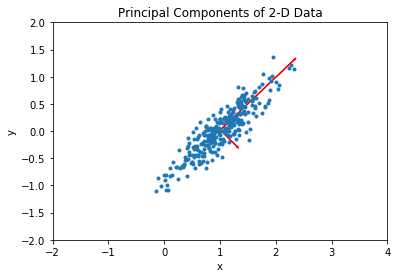

In [9]:
es = np.random.normal(size=[3, 300])
x = (1.5*es[0,:] + .25*es[1,:])*.3 + 1
y = es[0,:]*.4 + es[2,:]*.2

cov = np.cov([x, y])
ev, evec = np.linalg.eig(cov)

ux = mean(x)
uy = mean(y)

figure(figsize=[6, 4])
plot(x, y, '.')
xlim(-2, 4)
ylim(-2, 2);
xlabel('x')
ylabel('y');

arrow(ux, uy, -3*sqrt(ev[1])*evec[0, 1], -3*sqrt(ev[1])*evec[1, 1], width=.01, color='r')
arrow(ux, uy, 3*sqrt(ev[0])*evec[0, 0], 3*sqrt(ev[0])*evec[1, 0], width=.01, color='r');
title('Principal Components of 2-D Data');

## Link to eigenvectors

The projection $\hat{\bs u}^T \bt r$ is a random scalar:

* the variance of the projection is $\text{var}[\hat{\bs u}^T \bt r] = \hat{\bs u}^T V \hat{\bs u}$.
* the first eigen vector $\bs v_1$ of $V$ is therefore the principal component

If we limit ourselves to all $\bs u$ that is perpendicular to $\bs v_1$, then: 

* the second eigen vector $\bs v_2$ of $V$ is the principal component amongst all $\bs u$ with $\bs v_1^T \bs u = 0$
* this process can continue for all the eigen vectors

## Variance explained

The total variance of is sum of variance of in all $n$ elements of the random vector, which equals:

1. trace of $V$
2. sum of all eigen values of $V$

The portion of variance explained by the first $k$ eigenvectors is $\frac{\sum_i^k \lambda_i}{\sum_i^n \lambda_i}$. 

## Application in interest rates

CMT rates are constant maturity treasury bond yield that are published daily by <a href=http://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield>U. S. Treasury</a>.


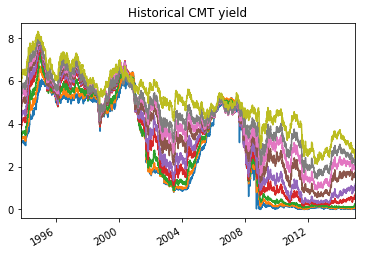

In [10]:
cmt_rates = pd.read_csv("data/cmt.csv", parse_dates=[0], index_col=[0])

cmt_rates.plot(legend=False, title='Historical CMT yield');

## Covariance matrix

* Covariance matrix between CMT rates at different maturities

In [11]:
tenors = cmt_rates.columns.map(float)
cv = cmt_rates.cov()
fmt.displayDF(cv, "4g")

,0.25,0.5,1,2,3,5,7,10,20
0.25,4.931,5.022,4.991,4.849,4.558,3.928,3.474,2.95,2.505
0.5,5.022,5.136,5.12,4.988,4.696,4.055,3.589,3.056,2.597
1,4.991,5.12,5.132,5.035,4.76,4.137,3.676,3.146,2.692
2,4.849,4.988,5.035,5.002,4.763,4.184,3.744,3.223,2.787
3,4.558,4.696,4.76,4.763,4.562,4.04,3.635,3.143,2.738
5,3.928,4.055,4.137,4.184,4.04,3.631,3.296,2.875,2.535
7,3.474,3.589,3.676,3.744,3.635,3.296,3.012,2.641,2.351
10,2.95,3.056,3.146,3.223,3.143,2.875,2.641,2.335,2.097
20,2.505,2.597,2.692,2.787,2.738,2.535,2.351,2.097,1.919


## IR PCA components

The eigenvectors and percentage explained, 

* the 1st principal component (PC) explains >95% of the variance
* the first 3 PCs can be interpreted as level, slope and curvature
* note that the sign of the PC is insignificant

In [12]:
xcv, vcv = np.linalg.eig(cv)
vcv = -vcv # flip the sign of eigen vectors for better illustratiaons

pct_v = np.cumsum(xcv)/sum(xcv)*100

import pandas as pd
pd.set_option('display.precision', 3)
fmt.displayDF(pd.DataFrame({'P/C':range(1, len(xcv)+1), 
                            'Eigenvalues':xcv, 'Cumulative Var(%)': pct_v}).set_index(['P/C']).T, "2f")

P/C,1,2,3,4,5,6,7,8,9
Cumulative Var(%),96.27,99.74,99.92,99.96,99.99,99.99,99.99,100.00,100.00
Eigenvalues,34.33,1.24,0.06,0.02,0.01,0.00,0.00,0.00,0.00


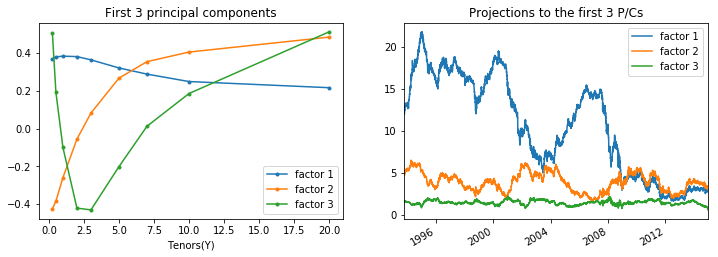

In [13]:
flab = ['factor %d' % i for i in range(1, 4)]

fig = figure(figsize=[12, 4])
ax1 = fig.add_subplot(121)
plot(tenors, vcv[:, :3], '.-');
xlabel('Tenors(Y)')
legend(flab, loc='best')
title('First 3 principal components');

fs = cmt_rates.dot(vcv).iloc[:, :3]

ax2 = fig.add_subplot(122)
fs.plot(ax=ax2, title='Projections to the first 3 P/Cs')
legend(flab, loc='best');

## Dimension reduction in MC

Given a generic $n$-dimensional SDE in vector form:

$$\renewcommand{Sigma}{\mathcal{S}} d \bs x = \bs u dt + A \Sigma d \bs w, \;\;\; d\bs w d\bs w^T = C dt$$

* $\Sigma$ is a diagonal matrix of $\sigma_i$ 
* $C$ is the correlation matrix of $d \bs w$, its covariance matrix $V = \Sigma C \Sigma$.

Recall Cholesky decomposition $V = LL^T$: $\Sigma \delta \bs w = L \bt z \sqrt{\delta t}$: 

$$
\small
\mathbb E [\Sigma\delta \bs w (\Sigma\delta \bs w)^T] = \mathbb E[(L \delta t \bt z \sqrt{\delta t}) (L \delta t \bt z \sqrt{\delta t})^T ] 
= L \mathbb E[\delta t \bt z\delta t \bt z^T] L^T \delta t = V \delta t
$$

* $\bt z$ is independent standard normal random vector.
* observe that the $L$ doesn't have to be square or triangular, as long as $V = LL^T$
* we can reduce $\bt z$ dimension by finding a rectanglar $\dot L$ so that $V \approx \dot L {\dot L}^T$

## Dimension reduction with PCA

Use the PCA of the covariance matrix: 
$$
\scriptsize
V = R_V \Lambda_V R_V^T \approx \dot R_V \dot \Lambda_V \dot R_V^T = \dot R_V \dot H_V \dot H_V^T  \dot R_V^T = (\overbrace{\dot R_V \dot H_V}^{L_V})(\dot R_V\dot H_V )^T \\$$
Or PCA on the correlation matrix:
$$
\scriptsize
V = \Sigma C \Sigma = \Sigma (R_C \Lambda_C R_C^T) \Sigma \approx \Sigma \dot R_C \dot \Lambda_C \dot R_C^T \Sigma = \Sigma \dot R_C \dot H_C \dot H_C^T  \dot R_C^T \Sigma^T = (\overbrace{\Sigma \dot R_C \dot H_C}^{L_C})(\Sigma \dot R_C\dot H_C )^T 
$$

* $\Lambda = H H^T$, both $\Lambda$ and $H$ are diagonal matrix with positive elements
* The dotted version only retains the first $k$ eigen values
* $\dot R$ and $L_V, L_C$ are $n \times k$ matrices; $\dot \Lambda$ are $k \times k$ matrices.

Simulation can then be driven by $\Sigma \delta \bs w = L \dot{\bt z} \sqrt{\delta t}$:
* Either $L_V = \dot R_V \dot H_V$ or $L_C = \Sigma \dot R_C \dot H_C$ works
* $\dot{\bt z}$ is of length $k$ only

## PCA is scale variant

Given the EVDs on covariance and correlation matrices:

$$R_V \Lambda_V R_V^T = V = \Sigma C \Sigma = \Sigma R_C \Lambda_C R_C^T \Sigma$$

Are they equivalent? 

* $\Sigma R_C \Lambda_C R_C^T \Sigma = (\Sigma R_C) \Lambda_C (\Sigma R_C)^T$
  * implies $\Lambda_C = \Lambda_V$ and $R_V = \Sigma R_C$

* $\Sigma R_C \Lambda_C R_C^T \Sigma = R_C (\Sigma \Lambda_C \Sigma) R_C^T$
  * implies $ \Lambda_V = \Sigma \Lambda_C \Sigma $ and $R_C = R_V$

However, neiher is true because: 
* $\Sigma R_C$ is not orthogonal: $(\Sigma R_C)(\Sigma R_C)^T = \Sigma R_C R_C^T \Sigma = \Sigma\Sigma \ne I$
  * $V = \Sigma C \Sigma$, $V$ and $C$ are not similar
* $\Sigma R_C \ne R_C \Sigma$, even when $\Sigma$ is diagonal.

There is no simple relationship btw these two EVDs.
* despite $C$ and $V$ are covariance matrix of $\bt r$ and $\Sigma^{-1} \bt r$ respectively

## Orthogonality depends on scale

The PCs are no longer orthogonal after stretching horizontally.

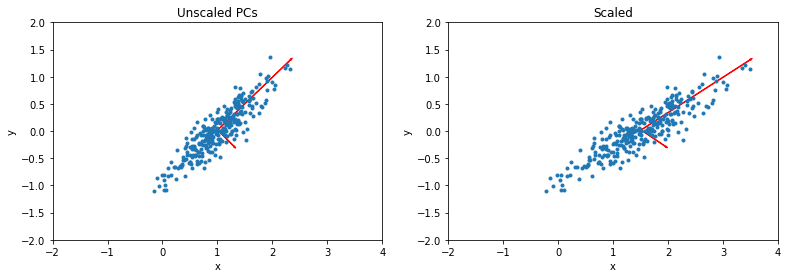

In [14]:
figure(figsize=[13, 4])
subplot(1, 2, 1)

plot(x, y, '.')
xlim(-2, 4)
ylim(-2, 2);
xlabel('x')
ylabel('y');

arrow(ux, uy, -3*sqrt(ev[1])*evec[0, 1], -3*sqrt(ev[1])*evec[1, 1], width=.01, color='r')
arrow(ux, uy, 3*sqrt(ev[0])*evec[0, 0], 3*sqrt(ev[0])*evec[1, 0], width=.01, color='r');
title('Unscaled PCs');

subplot(1, 2, 2)

scale = 1.5
plot(x*scale, y, '.')
xlim(-2, 4)
ylim(-2, 2);
xlabel('x')
ylabel('y');

arrow(ux*scale, uy, -3*sqrt(ev[1])*evec[0, 1]*scale, -3*sqrt(ev[1])*evec[1, 1], width=.01, color='r')
arrow(ux*scale, uy, 3*sqrt(ev[0])*evec[0, 0]*scale, 3*sqrt(ev[0])*evec[1, 0], width=.01, color='r');
title('Scaled');

## Before applying PCA 

PCA is a powerful technique, however, beware of its limitations:

* PCA factors are not real market risk factors
 * It does not lead to tradable hedging strategies
* PCA is not scale (or unit) invariant
 * it requires all the dimensions to have the same natural unit
 * mixing factors of different magnitude can lead to trouble: eg, mixing interest rates with equities
 * PCA results are different when applied to co-variance matrix and correlation matrix
 
PCA is usually applied to different data points of the same type

* different tenors/strikes of interest rates, volatiilty etc.
* price movements of the same sector/asset class

## PCA vs. least square

The PCA analysis has some similarity to the least square problem, both of them can be viewed as minimizing the L2 norm of residual errors. 

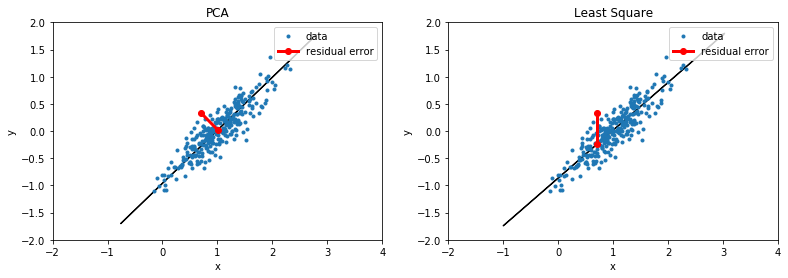

In [15]:
xs = np.array([x, np.ones(len(x))]).T
beta = np.linalg.inv(xs.T.dot(xs)).dot(xs.T).dot(y)

s_x, s_y = sp.symbols('x, y')
br = np.round(beta, 4)

figure(figsize=[13, 4])
subplot(1, 2, 1)
plot(x, y, '.')
xlim(-2, 4)
ylim(-2, 2);
xlabel('x')
ylabel('y');

dx = 4*sqrt(ev[0])*evec[0, 0]
dy = 4*sqrt(ev[0])*evec[1, 0]

arrow(ux-dx, uy-dy, 2*dx, 2*dy, width=.01, color='k');

ex = 3*sqrt(ev[1])*evec[0, 1]
ey = 3*sqrt(ev[1])*evec[1, 1]
plot([ux, ux+ex], [uy, uy+ey], 'r-o', lw=3)
legend(['data', 'residual error'], loc='best')

title('PCA');

subplot(1, 2, 2)
plot(x, y, '.')
xlim(-2, 4)
ylim(-2, 2);
xlabel('x')
ylabel('y');
arrow(-1, -1*beta[0]+beta[1], 4, 4*beta[0], width=.01, color='k');
y0 = (ux+ex)*beta[0] + beta[1]
plot([ux+ex, ux+ex], [y0, uy+ey], 'r-o', lw=3)
legend(['data', 'residual error'], loc='best')
title('Least Square');

## PCA or regression?

The main differences between PCA and least square (regression):

|  | PCA | Least Square/Regression |
| :-----: | :----: | :----: |
| Scale Invariant | No | Yes |
| Symmetry in Dimension | Yes | No |

To choose between the two:
* Use least square/regression when there are clear explanatary variables and causality
* Use PCA when there is a set of related variables but no clear causality
* PCA requires a natural unit for all dimensions

## What variable to apply PCA

It is important to choose the right variable to apply PCA. The main considerations are:

* Values or changes
 * Equity prices or returns?
 * IR levels or changes?
 * Key consideration: stationarity and mean reversion, horizon of your model prediction
 
* Spot or forward
 * Forward is usually a better choice than spot
 
Since the PCA is commonly applied to a correlation/covariance matrix, it is equivalent to ask what variables' correlation/covariance matrix we should model.

## Spurious correlation - equity price

Spurious correlation: variables can appear to be significantly correlated, but it is just an illusion:

In [16]:
f3 = pd.read_csv('data/f3.csv', parse_dates=[0]).set_index('Date').sort_index()
r = np.log(f3).diff()

fmt.displayDFs(f3.corr(), r.corr(), headers=['Price Correlation', 'Return Correlation'], fmt="4g")

## Spurious correlation - spot rates

The correlation between 9Y and 10Y spot rates and forward rates:

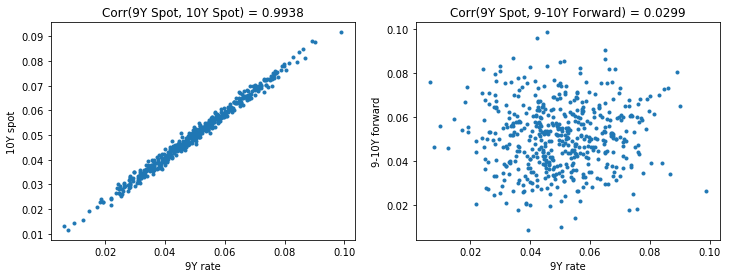

In [17]:
es = np.random.normal(size=[2, 500])
r0 = es[0,:]*.015 + .05
f1 = es[1,:]*.015 + .05

r1 = -np.log(np.exp(-9*r0-f1))/10


rc = np.corrcoef(np.array([r0, r1]))[0, 1]
fc = np.corrcoef(np.array([r0, f1]))[0, 1]

figure(figsize=[12, 4])
subplot(1, 2, 1)
plot(r0, r1, '.')
xlabel('9Y rate')
ylabel('10Y spot')
title('Corr(9Y Spot, 10Y Spot) = %.4f'% rc)

subplot(1, 2, 2)
plot(r0, f1, '.')
xlabel('9Y rate')
ylabel('9-10Y forward')
title('Corr(9Y Spot, 9-10Y Forward) = %.4f'% fc);

$$\begin{eqnarray}
\exp(-10 r_{10}) &=& \exp(-9 r_9)\exp(-(10-9) f(9, 10) )  \\
r_{10} &=& 0.9r_9 + 0.1f(9, 10) 
\end{eqnarray}$$

* the $f(9, 10)$ is the 9Y to 10Y forward rate.
* of course $r_{10} = f(0, 10)$

## Correlated by construction

$$ r_{10} = 0.9r_9 + 0.1f(9, 10) $$

* The high correlation between spot rates to similar tenors are by construction
* PCA analysis can be misleading in percentage of variance explained
  * the variance of spot rates of short tenors are counted multiple times
* May not be a problem if we have unlimited precision, but we usually only keep the first few eigen vectors in PCA
* it's usually better to model the correlation/covariance matrix of forward rates

# Singular Value Decomposition

rotate, stretch and rotate, then you get back to square one, that's pretty much the life in a bank.

## Definition

For any real matrix $M$, $\sigma > 0$ is a singular value if there exists two vectors $\bs {u, v}$ such that:

1. $M \bs v = \sigma \bs u$ 
2. $M^T \bs u = \sigma \bs v$

$\bs {u, v}$ are called left and right singular vector of $M$.
* unlike eigenvalues, singular values are always positive.

By convention, 
* we represent singular vectors as unit L-2 vectors, i.e., $\bs u^T\bs u = \bs v^T \bs v = 1$,
* we name the singular values in descending order as $\sigma_1, \sigma_2, ..., \sigma_n$, and refer corresponding singular vector pairs as $ (\bs u_1, \bs v_1), (\bs u_2, \bs v_2), ..., (\bs u_n, \bs v_n) $.

## Singular vectors and maximization

Consider $\bs u^T M \bs v$ for real matrix $M$:

* $\bs {u_1, v_1}$ maximize $\bs u^T M \bs v$ amongst all unit $\bs {u, v}$ vectors. 

Apply the Lagrange multiplier, with constraints $\bs u^T  \bs u = \bs v^T  \bs v = 1$:

$$\small \begin{array} 
\\l &= \bs u^T M \bs v - \lambda_1 (\bs u^T  \bs u - 1) - \lambda_2 (\bs v^T  \bs v - 1) \\
\frac{\partial l}{\partial{\bs u^T}} &= M \bs v - 2 \lambda_1 \bs u = \bs 0 \iff \bs u^T M \bs v - 2 \lambda_1 = \bs 0\\
\frac{\partial l}{\partial{\bs v}} &= \bs u^T M  - 2\lambda_2 \bs v^T = \bs 0^T \iff \bs u^T M \bs v- 2\lambda_2 = \bs 0
\end{array}$$

Therefore,
$$ 2\lambda_1 = \small \bs u^T M \bs v  = 2\lambda_2 $$
$$M \bs v = \sigma \bs u \;,\; M^T\bs u = \sigma \bs v $$

## Orthogonality of Singular Vectors

Given $\bs{u_1, v_1}$ are the first singular vectors of $M$:

$$\bs x^T \bs v_1 = 0  \iff (M \bs x)^T \bs u_1 = 0 \iff \bs u_1^T M \bs x  = 0 $$

because:

$$ (M \bs x)^T \bs u_1 = \bs x^T M^T \bs u_1 = \bs x^T \sigma_1 \bs v_1  = 0 $$

Therefore, if we only consider those $\bs u^T \bs u_1^ = 0$, the corresponding $\bs v$ must be orthogonal to $\bs v_1$ :

* $\bs {u_2, v_2}$ maximizes $\bs u^T M \bs v$  among those $(\bs u, \bs v)$ orthogonal to $\bs u_1, \bs v_1$
* this process can repeat for all singular vectors (assuming singular values are distinct)

## Singular value decmposition

We can write all singular vectors and singular values in matrix format, which is the singular value decomposition (SVD):

$$
U^T M V = \Sigma \iff M = U \Sigma V^T
$$

| | $M$ | $U$ | $\Sigma$ | $V$ |
| :---: | :---: | :----: | :----: | :---: |
| Name | Original Matrix | Left singular vector | Singular value | Right singular vector |
| Type |  Real | Orthogonal, real | Diagonal, positive | Orthogonal, real |
| Size | $m \times n$ | $m\times m$ | $m\times n$ | $n \times n$ |

* For matrix $M$, there can only be $\min(m, n)$ singular values at most
* The left/right singular vectors form a basis for the vector space of $\bs {u}$ and $\bs v$ respectively

## Graphical representation of SVD

Illustration from wikipedia:

<center> <img src="img/svd.png" width=500 height=500></center>

## Link between SVD and EVD


$$
M = U \Sigma V^T
$$

SVD and eigenvalue decomposition (EVD) are closely related to each other:

* SVD reduces to EVD if $M$ is symmetric positive definite
* $MM^T = U \Sigma V^T V \Sigma^T U^T = U \Sigma \Sigma^T U^T$:
  * the column vectors of $U$ are the eigen vectors of $MM^T$
* $M^TM = V\Sigma^TU^TU\Sigma V^T = V \Sigma\Sigma^T V^T$: 
  * the column vectors of $V$ are the eigen vectors of $M^TM$
* The singular values are the positive square roots of eigen values of $MM^T$ or $M^TM$

## SVD of pseudo inverse

Given the SVD decomposition $X = U\Sigma V^T$, the SVD of $X$'s pseudo inverse is:

$$X^+ = (X^TX)^{-1}X^T = V \Sigma^+ U^T$$

where $\Sigma^+$ is the pseudo inverse of $\Sigma$, whose diagonal elements are the reciprocals of those in $\Sigma$.

Proof: the last equation is obviously true, and every step is reversible:

$$\begin{array}&(X^TX)^{-1}X^T &= V\Sigma^+ U^T \\
(V \Sigma^T \Sigma V^T)^{-1} V\Sigma^TU^T &= V\Sigma^+ U^T \\
(V \Sigma^T \Sigma V^T)^{-1} V\Sigma^T\Sigma &= V \Sigma^+\Sigma \\
(V \Sigma^T \Sigma V^T)^{-1} V\Sigma^T\Sigma &= V \\
(V \Sigma^T \Sigma V^T)^{-1} (V\Sigma^T\Sigma V^T) &= I 
\end{array}$$

SVD is another way to solve the least square problem.

## L2 norm and condition number

Consider a real matrix $A$, its L2 norm is defined as the maximum of $\frac{\Vert A \bs x \Vert_2}{\Vert \bs x \Vert_2}$:

$$
\Vert A \Vert_2^2 = \max_{\bs x} \frac{\Vert A \bs x \Vert_2^2}{\Vert \bs x \Vert_2^2} 
= \max_{\bs x} \frac{\bs x^T A^T A \bs x}{\bs x^T \bs x} 
= \max_{\hat{\bs x}} \hat{\bs x}^T A^T A \hat{\bs x} = \sigma_1(A)^2$$

where $\hat{\bs x} = \frac{\bs x}{\Vert \bs x \Vert_2}$ is a unit vector, and $\sigma_1(A)$ is the largest singular value of $A$.

For a generic non-square matrix $A$:
* the L-2 norm of a matrix is its largest singular value: $\Vert A \Vert_2 = \sigma_1(A)$
* the L-2 norm of the pseudo inverse $A^+$: $\Vert A^+ \Vert_2 = \frac{1}{\sigma_n(A)}$
  * $\sigma_n(A)$ is the smallest singular value of $A$.
* the L-2 condition number of a matrix $A$ is therefore: $k(A) = \Vert A \Vert_2 \Vert A^+ \Vert_2 = \frac{\sigma_1(A)}{\sigma_n(A)}$

## SVD and condition number

SVD offers clear intuitions in understanding the L-2 condition number of a Matrix $A$.

For a linear system $\bs y = A \bs x$, consider a perturbation $\delta \bs x$ to the input $\bs x$:

* if $\delta \bs x$ is stretched by a larger factor than $\bs x$, then the relative error grows.
* the worst case occurs when $\bs x$ is stretched by $\sigma_n(A)$, while $\delta \bs x$ is stretched by $\sigma_1(A)$
  * the relative error grows by a factor of $\frac{\sigma_1(A)}{\sigma_n(A)}$.
* Orthogonal matrix represents a pure rotation
  * all singular values are 1, no stretches, thus the relative error does not grow

## Spot the trouble

When working with near singular matrix,  SVD can identify ill-conditioned area:

* real world covariance and correlation matrix are often near singular
* numerical instability arises when inputs are very close to signular vectors with small singular values 
  * e.g, when return forecast is in the same direction as the last singular vector ...

## Rank deficiency and reduction

Singular matrix are those that are not fully ranked
* Square matrix: non-invertible, its determinant is 0
* In practice, matrices are rarely exactly singular due to numerical errors

SVD can detect near singular matrices
* near singular matrix has very small singular values

SVD can find low rank approximations to a full rank matrix
* by zeroing out small singular values

## Condition number for EVD

What is the change in $\lambda_i$ if we perturb the symmetric matrix $A$? 

$$ A \bs v_i = \lambda_i \bs v_i$$

Apply the perturbation analysis: $\delta A = \dot{A} \epsilon, \delta \lambda_i = \dot{\lambda_i} \epsilon, 
\delta \bs v_i = \dot{\bs v_i} \epsilon$, the first order terms of $\epsilon$:

$$\begin{array} 
\\ (A + \dot{A}\epsilon )(\bs v_i + \dot{\bs v_i}\epsilon) &= (\lambda_i + \dot{\lambda_i}\epsilon) (\bs v_i + \dot{\bs v_i} \epsilon) \\
\dot{A}\bs v_i + A \dot{\bs v_i} &= \lambda_i \dot{\bs v_i} + \dot{\lambda_i}\bs v_i \\
\bs v_i^T\dot{A}\bs v_i + \bs v_i^T A \dot{\bs v_i} &= \bs v_i^T \lambda_i \dot{\bs v_i} + \bs v_i^T \dot{\lambda_i}\bs v_i \\
\bs v_i^T\dot{A}\bs v_i &= \dot{\lambda_i}
\end{array}$$

Therefore:
$$\begin{array}
\\ \frac{ | \delta \lambda_i |}{| \lambda_i |} &= \frac{\Vert \bs v_i^T\delta A \bs v_i\Vert_2}{|\lambda_i|}
\le \frac{\Vert \delta A \Vert_2}{|\lambda_i|} = \frac{\Vert A\Vert_2}{|\lambda_i|} \frac{\Vert \delta A \Vert_2}{\Vert A \Vert_2}
 = \left\vert \frac{\lambda_1}{\lambda_i}\right\vert \frac{\Vert \delta A \Vert_2}{\Vert A \Vert_2} 
 \end{array}$$
 
* The eigenvalue's conditional number for a symmetric matrix $A$ is therefore the ratio from the largest eigen value: $k(A) = \left\vert \frac{\lambda_1}{\lambda_i} \right\vert$.
* The smaller eigenvalues are less accurate, we should ignore them.

## Decomposition summary
 
For real matrix $A$:
 
| Decomposition | Applicability | Formula | Results | Key applications |
| :---: | :---: | :---: | :---: | 
| LU | square, full rank | $A = LU$ | lower, upper triangluar | matrix inversion |
| Cholesky | symmetric positive definite | $A = LL^T$ | lower triangular | simulate correlated factors |
| QR | any | $A = Q R$ | orthogonal, upper triangular | solve eigen values, least square|
| EVD | symmetric | $A = R\Lambda R^T$ | orthogonal, real diagonal | PCA |
| SVD | any | $A = U\Sigma V^T$ | orthogonal, positive diagonal, orthogonal | error analysis, rank reduction |


# Assignment

Requried reading:

* Bindel and Goodman: Chapter 4

Recommended reading:

* Andersen and Piterbarg: 4.1

Homework: 

* [Homework set 3](http://yadongli.github.io/nyumath2048/)